## Import Libraries

In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data Preprocessing

### Data Loading

In [22]:
dir = '/kaggle/input/human-face-emotions/data'

image_dir = Path(dir)
filename = list(image_dir.glob(r'**/*.jpg'))
label = list(map(lambda x:os.path.split(os.path.split(x)[0])[1],filename))

filename = pd.Series(filename, name='Filepath').astype(str)
label = pd.Series(label, name='Label')
image_dataframe = pd.concat([filename, label], axis=1)

image_dataframe.head()

,Filepath,Label
0,/kaggle/input/human-face-emotions/data/Angry/1...,Angry
1,/kaggle/input/human-face-emotions/data/Angry/f...,Angry
2,/kaggle/input/human-face-emotions/data/Angry/g...,Angry
3,/kaggle/input/human-face-emotions/data/Angry/s...,Angry
4,/kaggle/input/human-face-emotions/data/Angry/A...,Angry


### Data Visualization

In [23]:
image = plt.imread(image_dataframe['Filepath'].iloc[1])
image.shape

(1080, 1000, 3)

Images are 1080x1000 RGB pictures.

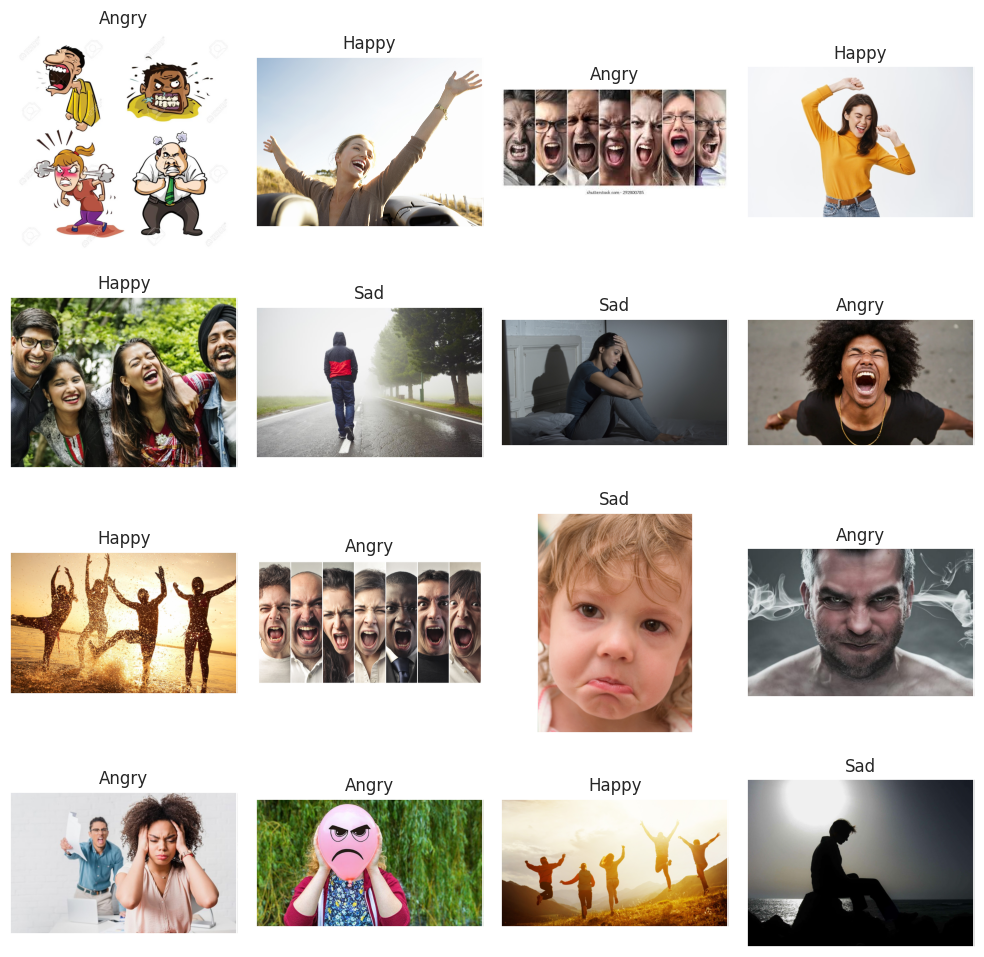

In [14]:
random_index = np.random.randint(0,len(img_df),16)
fig,axes = plt.subplots(nrows=4,ncols=4,figsize=(10,10),subplot_kw={'xticks':[],'yticks':[]})

for i,ax in enumerate(axes.flat):
  img = plt.imread(img_df['Filepath'].iloc[random_index[i]])
  ax.imshow(img)
  ax.set_title(img_df['Label'].iloc[random_index[i]])
plt.tight_layout()
plt.show()

### Data Splitting

In [117]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_dataframe = image_dataframe.sample(frac=1, random_state=42).reset_index(drop=True)

training, test = train_test_split(image_dataframe, test_size=0.1, random_state=42)
train, valid = train_test_split(training, test_size=0.2, random_state=42)

train = train.sample(frac=1, random_state=42).reset_index(drop=True)
valid = valid.sample(frac=1, random_state=42).reset_index(drop=True)
test = test.sample(frac=1, random_state=42).reset_index(drop=True)

### Data Augmentation

In [168]:
datagen_train = ImageDataGenerator(
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,             
    rescale=1./255                   
)

datagen_test = ImageDataGenerator(
    rescale=1./255
)

train_set = datagen.flow_from_dataframe(dataframe=train,
                                        x_col='Filepath',
                                        y_col='Label',
                                        batch_size=32,
                                        target_size=(224,224),
                                        shuffle=True,
                                        seed=42,
                                        class_mode='categorical'
                                        )

val_set = datagen_test.flow_from_dataframe(dataframe=val,
                                        x_col='Filepath',
                                        y_col='Label',
                                        batch_size=32,
                                        target_size=(224,224),
                                        shuffle=True,
                                        seed=42,
                                        class_mode='categorical'
                                        )

test_set = datagen_test.flow_from_dataframe(dataframe=test,
                                        x_col='Filepath',
                                        y_col='Label',
                                        batch_size=32,
                                        target_size=(224,224),
                                        shuffle=False,
                                        seed=42,
                                        class_mode='categorical'
                                        )

Found 155 validated image filenames belonging to 3 classes.
Found 39 validated image filenames belonging to 3 classes.
Found 22 validated image filenames belonging to 3 classes.


## Model Implementation

In [169]:
from keras import Sequential
from keras.layers import Dense, MaxPool2D, Conv2D, Flatten, Dropout, BatchNormalization

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 110, 110, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 53, 53, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,195,811 (73.23 MB)

 Trainable params: 19,195,363 (73.22 MB)

 Non-trainable params: 448 (1.75 KB)

In [170]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [178]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [179]:
history = model.fit(train_set,
                    validation_data=val_set,
                    epochs=25,
                    verbose=1,
                   callbacks=[early_stopping, reduce_lr])

Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.5143 - loss: 3.2158 - val_accuracy: 0.3077 - val_loss: 2.6511 - learning_rate: 8.0000e-06
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - accuracy: 0.5241 - loss: 3.9493 - val_accuracy: 0.3077 - val_loss: 2.7597 - learning_rate: 8.0000e-06
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.5831 - loss: 3.3458 - val_accuracy: 0.3077 - val_loss: 2.8685 - learning_rate: 8.0000e-06
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.5073 - loss: 3.4187 - val_accuracy: 0.3077 - val_loss: 2.9851 - learning_rate: 8.0000e-06
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.4908 - loss: 3.7031 - val_accuracy: 0.3077 - val_loss: 3.1090 - learning_rate: 1.6000e-06
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.5497 - loss: 3.1757 - val_accuracy: 0.3077 - val_loss: 3.2305 - learning_rate: 1.6000e-06
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.5322 - loss: 2.9000 - val_

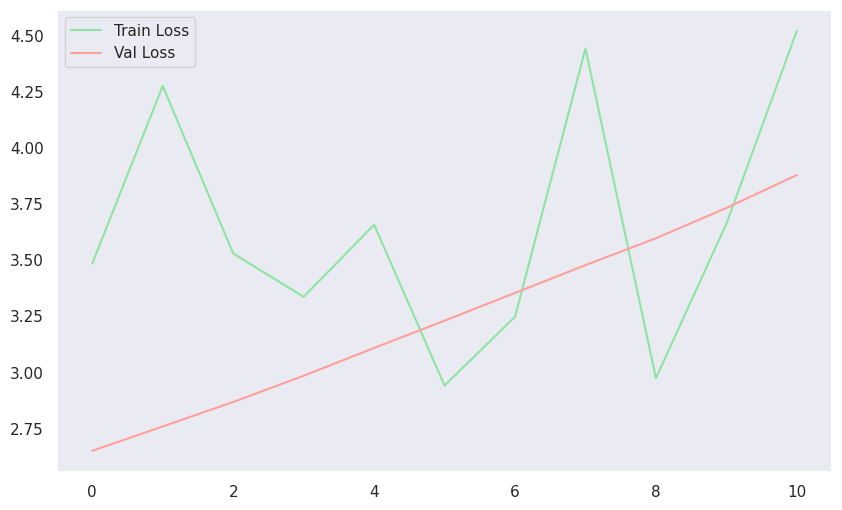

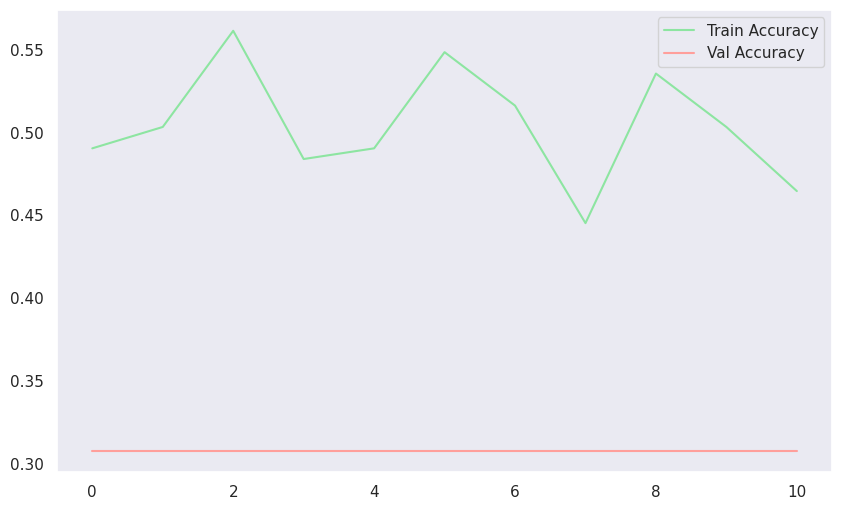

In [180]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'],label='Train Loss',c='g')
plt.plot(history.history['val_loss'],label='Val Loss',c='r')
plt.grid()
plt.legend()

plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'],label='Train Accuracy',c='g')
plt.plot(history.history['val_accuracy'],label='Val Accuracy',c='r')
plt.grid()
plt.legend()
plt.show()

In [181]:
test_loss, test_accuracy = model.evaluate(test_set,steps=len(test_set),verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 2.2542333602905273
Test Accuracy: 0.40909090638160706


In [182]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

y_true = test_set.classes

report = classification_report(y_true, y_pred, target_names=test_set.class_indices)
print("Classification Report :")
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Report :
              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00         6
       Happy       0.00      0.00      0.00         7
         Sad       0.41      1.00      0.58         9

    accuracy                           0.41        22
   macro avg       0.14      0.33      0.19        22
weighted avg       0.17      0.41      0.24        22



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [183]:
sample_images, sample_labels = next(test_set)
sample_predictions = model.predict(sample_images)
sample_predictions_labels = np.argmax(sample_predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step


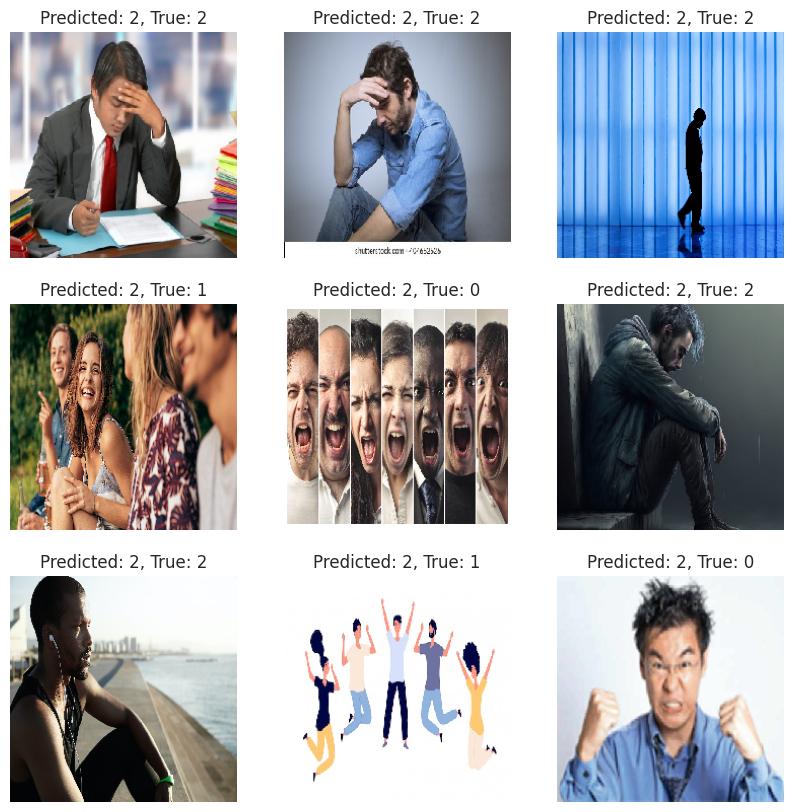

In [184]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Predicted: {sample_predictions_labels[i]}, True: {np.argmax(sample_labels[i])}")
    plt.axis('off')
plt.show()